In [4]:
# Run this first!!!
from IPython.display import display, HTML

from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import brentq

import sys
sys.path.append('..')
import util
sys.path.append('../aho_merging')
from size_model import SizeModel
sys.path.append('../common')
import common_probs
from sampler import DepthSampler

In [26]:
def plot_trends(num_samples, length, gamma):
    depths = range(1, length + 1)
    alg_trend = get_alg_trend(num_samples, length)[1:]
    plt.plot(depths, alg_trend, label='Algorithm')
    geom = approximate_geometric_dist(0.55, 10)
    model_trend = get_model_trend(num_samples, length, 1, geom)
    plt.plot(depths, model_trend, linestyle='--', label='Model')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Depth')
    plt.ylabel('Average Number of Threads')
    plt.title('Average Number of Threads vs Depth')
    plt.show()
    
def get_alg_trend(num_samples, length):
    ds = DepthSampler([0.5 for _ in range(4)], length)
    df = ds.draw_samples(num_samples, ['threads'])
    return df.groupby('depth')['threads'].mean().tolist()
    
def get_model_trend(num_samples, length, mu_x, dist):
    model = SizeModel(mu_x, dist)
    return model.do_sims(length, num_samples)

def approximate_geometric_dist(p, possible_offspring):
    dist = [0 for _ in range(possible_offspring + 1)]
    dist[1] = (1 - p) * p
    for i in range(2, possible_offspring + 1):
        dist[i] = (1 - p) * dist[i - 1]
    dist[0] = 1 - sum(dist)
    return dist

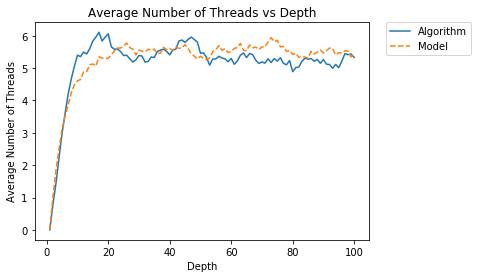

In [28]:
# Constants
NUM_SAMPLES = 1000
LENGTH = 100
GAMMA = 5.5

plot_trends(NUM_SAMPLES, LENGTH, GAMMA)


## Plot Everything

In attempt to figure out some analytical way to determine the parameters I will try to sample and plot as many aspects of the "threads" as possible.

In [5]:
def sample(probs, length, samples):
    ds = DepthSampler(probs, length)
    return ds.draw_samples(samples, ['threads', 'thread_children', 'new_thread'])

def plot_average_new_thread_by_depth(df, length):
    depths = range(length + 1)
    new_thread_trend = df.groupby('depth')['new_thread'].mean().tolist()
    plt.plot(depths, new_thread_trend)
    plt.xlabel('Depth')
    plt.ylabel('Average Number of New Threads')
    plt.title('Average Number of New Threads vs Depth')
    plt.show()
    
def plot_average_offspring_by_depth(df, length):
    depths = range(length + 1)
    cpy = df
    cpy['mean_thread_children'] = (cpy['thread_children']
                                  .map(lambda l: 0 if len(l) == 0 else sum(l) / len(l)))
    offspring_trend = cpy.groupby('depth')['mean_thread_children'].mean().tolist()
    plt.plot(depths, offspring_trend)
    plt.xlabel('Depth')
    plt.ylabel('Average Thread Offspring')
    plt.title('Average Thread Offspring vs Depth')
    plt.show()
    
def plot_asym_offspring_dist(df, length):
    max_sample = 0
    samples = []
    for _, children in df[df['depth'] == length - 1]['thread_children'].iteritems():
        samples += children
        if len(children) > 0:
            curr_max = max(children)
            max_sample = curr_max if curr_max > max_sample else max_sample
    sample_mean = np.mean(samples)
    sample_stddev = np.std(samples)
    int_bins = [-0.5 + i for i in xrange(max_sample + 2)]
    plt.hist(samples, bins=int_bins)
    plt.xlabel('Number of Offspring')
    plt.ylabel('Frequency')
    plt.title('Offspring Distribution; Depth: %d; Samples: %d; Mean: %f; Std Dev: %f' 
              % ((length - 1), len(samples), sample_mean, sample_stddev))
    plt.show()
    
def plot_all(probs, length, samples):
    df = sample(probs, length, samples)
    plot_average_new_thread_by_depth(df, length)
    plot_average_offspring_by_depth(df, length)
    plot_asym_offspring_dist(df, length)

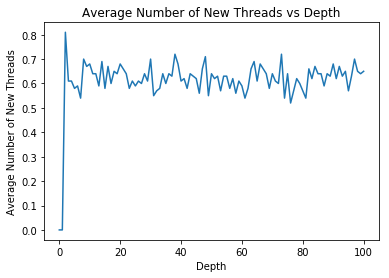

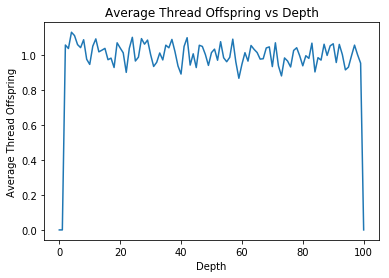

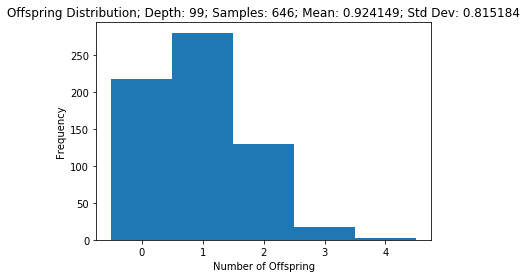

In [6]:
# PARAMETERS
ALPHABET_PROBS = [0.5 for _ in xrange(4)] # Probability of seeing each letter.
LENGTH = 100 # Length of the generalized strings to test.
SAMPLES = 100 # Number of randomly generated strings to try.

plot_all(ALPHABET_PROBS, LENGTH, SAMPLES)